# [COM6513] Assignment 1: Sentiment Analysis with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test a **text classification** system for **sentiment analysis**, in particular to predict the sentiment of movie reviews, i.e. positive or negative (binary classification).



For that purpose, you will implement:


- Text processing methods for extracting Bag-Of-Word features, using 
    - n-grams (BOW), i.e. unigrams, bigrams and trigrams to obtain vector representations of documents where n=1,2,3 respectively. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). 
    - character n-grams (BOCN). A character n-gram is a contiguous sequence of characters given a word, e.g. for n=2, 'coffee' is split into {'co', 'of', 'ff', 'fe', 'ee'}. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). **Tip: Note the large vocabulary size!** 
    - a combination of the two vector spaces (n-grams and character n-grams) choosing your best performing wighting respectively (i.e. raw or tfidf). (**1 mark**) **Tip: you should merge the two representations**



- Binary Logistic Regression (LR) classifiers that will be able to accurately classify movie reviews trained with: 
    - (1) BOW-count (raw frequencies) 
    - (2) BOW-tfidf (tf.idf weighted)
    - (3) BOCN-count
    - (4) BOCN-tfidf
    - (5) BOW+BOCN (best performing weighting; raw or tfidf)



- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function (**1 mark**)
    - Use L2 regularisation (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous development loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)



- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength) for each LR model? You should use a table showing model performance using different set of hyperparameter values. (**2 marks). **Tip: Instead of using all possible combinations, you could perform a random sampling of combinations.**


- After training each LR model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot. Does your model underfit, overfit or is it about right? Explain why. (**1 mark**). 


- Identify and show the most important features (model interpretability) for each class (i.e. top-10 most positive and top-10 negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!). If you were to apply the classifier into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 


- Provide efficient solutions by using Numpy arrays when possible (you can find tips in Lab 1 sheet). Executing the whole notebook with your code should not take more than 5 minutes on a any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs (**2 marks**). 






### Data 

The data you will use are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.




### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex` or you can print it as PDF using your browser).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 14 Mar 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import math

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
df_train = pd.read_csv('data_sentiment/train.csv',names=['raw_text', 'class'])# train set
df_test = pd.read_csv('data_sentiment/test.csv', names=['raw_text', 'class'])# test set
df_dev = pd.read_csv('data_sentiment/dev.csv', names=['raw_text', 'class'])# develpment set

If you use Pandas you can see a sample of the data.

In [3]:
df_train.head(5)

,raw_text,class
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [4]:
def text_to_list(df):
    return (list(df['raw_text']))
def class_to_array(df):
    return (np.array(df['class']))

In [5]:
text_dev = text_to_list(df_dev)
text_train = text_to_list(df_train)
text_test = text_to_list(df_test)

label_dev = class_to_array(df_dev)
label_train = class_to_array(df_train)
label_test = class_to_array(df_test)

# Vector Representations of Text 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams (or character ngrams from the unigrams)
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (or character n-grams). You can keep top N if you encounter memory issues.


In [6]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `char_ngrams`: boolean. If true the function extracts character n-grams

and returns:

- `x': a list of all extracted features.

See the examples below to see how this function should work.

In [7]:
def extract_ngrams(x_raw, # raw text
                   ngram_range=(1,3), # a tuple of two integers
                   token_pattern=r'\b[A-Za-z]{2,}\b',# "regular expression" r"[^a-zA-Z0-9]"
                   stop_words= stop_words, 
                   vocab=None,
                   char_ngrams=False):
    
    tokens = [] # initial the tokens into an empty list
    words = [word.lower() for word in re.findall(token_pattern, x_raw)]# tokenisaztion and transform in regular expression
    for i in range(len(words)):
        words[i] = words[i].lower() 
        if  words[i] not in stop_words   : # search ever word not in stoplist  in re.findall(token_pattern, x_raw)
            tokens.append(words[i]) # then append it to the tokens list in lower case
    if char_ngrams == False:
        n_grams = [] # initial the n_grames
        for n in range(ngram_range[0], ngram_range[-1] + 1):
            if n == 1:
                n_grams += tokens
            else:
                # Create bigram / trigram by unzipping list
                n_grams += zip(*(tokens[i:] for i in range(n))) # zip the list of token[1] to token[1+n], then token[2], token[2+n]
        return [ngram for ngram in n_grams if ngram in vocab] if vocab else n_grams
    
    if char_ngrams == True:
        n_grams = [] # initial the n_grames
        for word in tokens:
            for n in range(ngram_range[0], ngram_range[-1] + 1):
                if n == 1:
                    n_grams += [word[i] for i in range(len(word))]
                else:
                # Create bigram / trigram by unzipping list
                    n_grams += zip(*(word[i:] for i in range(n))) # zip the list of token[1] to token[1+n], then token[2], token[2+n]
        return [ngram for ngram in n_grams if ngram in vocab] if vocab else n_grams

In [8]:
extract_ngrams('this is a Great movie! to watch',
               ngram_range=(1, 3),
               vocab={'great', ('great', 'movie')})

['great', ('great', 'movie')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

For extracting character n-grams the function should work as follows:

In [9]:
extract_ngrams("This is great movie movie  to watch", 
               ngram_range=(2,4), 
               stop_words=stop_words,
               char_ngrams=False)

[('great', 'movie'),
 ('movie', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'movie'),
 ('movie', 'movie', 'watch'),
 ('great', 'movie', 'movie', 'watch')]

In [10]:
extract_ngrams("This is great movie to watch", 
               ngram_range=(2,2), 
               stop_words=stop_words,
               char_ngrams=True)

[('g', 'r'),
 ('r', 'e'),
 ('e', 'a'),
 ('a', 't'),
 ('m', 'o'),
 ('o', 'v'),
 ('v', 'i'),
 ('i', 'e'),
 ('w', 'a'),
 ('a', 't'),
 ('t', 'c'),
 ('c', 'h')]

### Create a vocabulary 

The `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [11]:
def get_vocab(X_raw,
              ngram_range=(1, 3),
              token_pattern=r'\b[A-Za-z]{2,}\b',
              min_df=1,
              keep_topN=None,
              stop_words=stop_words,
              char_ngrams = False):
    
    # df: Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
    # ngram_counts: counts of each ngram in vocab
    df = Counter()
    ngram_counts = Counter()

    for one_review in X_raw:
        # make the n_gram of each review in set of texts in a list
        ngrams = extract_ngrams(one_review, ngram_range, token_pattern, stop_words, char_ngrams = char_ngrams)
        
        # Count document frequency and using update to counter for each n_gram
        df.update(set(ngrams)) # term freq
        # Count ngram frequency, we count the ngram in ngrams if it achieve a higher freq > min_df
        ngram_counts.update(ngram for ngram in ngrams if df[ngram] >= min_df) # total
   
    # Extract ngram into vocab set
    vocab = {ngram for ngram, counts in ngram_counts.most_common(keep_topN)}

    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [12]:
vocab, df, ngram_counts = get_vocab(text_train, keep_topN=5000)

In [13]:
print("Vocab: \n", list(vocab)[:50])
print("\n Raw frequencies of n-grams: \n", df.most_common()[:10])
print("\n Counts of each ngram in vocab \n", ngram_counts.most_common()[:10])

Vocab: 
 ['surprise', 'placed', 'ways', 'viewer', ('tv', 'show'), 'believe', 'wonderful', 'kate', 'missed', ('julia', 'roberts'), 'going', 'grace', 'rare', 'hack', 'francis', 'leaves', 'menace', 'center', 'flubber', 'endings', 'considering', ('him', 'but'), 'looks', 'midst', 'repetitive', 'cuts', ('good', 'hunting'), 'seek', 'took', 'fishburne', 'ryan', 'involved', ('but', 'seems'), 'lloyd', 'non', ('but', 'after'), 'design', 'someone', 'irony', 'raimi', 'rising', 'terrible', 'brief', ('characters', 'all'), 'unexpected', 'phantom', 'favor', ('original', 'film'), 'discovery', 'yeah']

 Raw frequencies of n-grams: 
 [('but', 1334), ('one', 1247), ('film', 1231), ('not', 1170), ('all', 1117), ('movie', 1095), ('out', 1080), ('so', 1047), ('there', 1046), ('like', 1043)]

 Counts of each ngram in vocab 
 [('film', 6769), ('but', 6156), ('one', 4156), ('movie', 4125), ('not', 3934), ('all', 3055), ('there', 2641), ('like', 2616), ('so', 2591), ('out', 2580)]


Then, you need to create 2 dictionaries: (1) vocabulary id -> word; and  (2) word -> vocabulary id so you can use them for reference:

In [14]:
#create a vocab_id to word dictionary
id2word = dict(enumerate(vocab))
word2id = {i:w for w, i in id2word.items()}

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [15]:
train_ngram = (extract_ngrams(review, ngram_range=(1, 3), vocab = vocab)for review in text_train)
test_ngram = (extract_ngrams(review, ngram_range=(1, 3), vocab = vocab)for review in text_test)
dev_ngram = (extract_ngrams(review, ngram_range=(1, 3), vocab = vocab)for review in text_dev)

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [16]:
def vectorise(X_ngram, vocab):
    X_vec = []
    for ngrams in X_ngram: 
        count_ngram = Counter(ngrams)
        X_vec.append([count_ngram[v] for v in vocab]) # The list will follow the order of vocab 
    return np.array(X_vec)

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [17]:
train_count = vectorise(train_ngram, vocab)
dev_count = vectorise(dev_ngram, vocab)
test_count = vectorise(test_ngram, vocab)

In [18]:
train_count.shape, dev_count.shape, test_count.shape

((1400, 5000), (200, 5000), (400, 5000))

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [19]:
def tfidf(count_matrix, vocab, df):
    df_voc = []
    idfs = []
    for v in vocab:
        df_voc.append(df[v])# follow the vocab order,plus freq as order
  
    for freq in df_voc:# some word in vacab may not appear in test or val text,so need identify
        if freq != 0:
            idfs.append(np.log10(len(count_matrix)/ freq))# do the calc
        else:
            idfs.append(0)# if the document freq is 0, cant divide, here add 0
    idf_matrix = np.array(idfs)   
    idf = np.array([np.log10(len(count_matrix)/freq)]) #idf matrix
    
    tfidf = np.log10(1 + count_matrix) * idf_matrix #tfidf
    return tfidf

In [20]:
_,dev_df, _ = get_vocab(text_dev, keep_topN=5000)
_,test_df,_ = get_vocab(text_test, keep_topN=5000)

Then transform your count vectors to tf.idf vectors:

In [21]:
train_tfidf = tfidf(train_count, vocab, df)
test_tfidf = tfidf(test_count, vocab, dev_df)
dev_tfidf = tfidf(dev_count, vocab, test_df)

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [22]:
def sigmoid(z):
    sig = 1 / (1 + np.exp(-z))
    return sig

Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [23]:
def predict_proba(X, weights):
    preds_proba = sigmoid(np.dot(X, weights)) # sigmid (z = w*x) 
    return preds_proba # returns a probability of positive results

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [24]:
def predict_class(X, weights):
    preds_class = []
    for prob in predict_proba(X, weights):
        if prob < 0.5:
            preds_class.append(0)# Negative prob < 0.5
        else:
            preds_class.append(1)# Postive
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [25]:
def binary_loss(X, Y, weights, alpha=0.00001):
    l = -Y * np.log(predict_proba(X, weights)) - (1 - Y) * np.log(1 - predict_proba(X, weights))
    # L2 Regularisation
    + alpha * weights.dot(weights)

    # Return the average loss
    return np.mean(l)

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [26]:
def SGD(X_tr,
        Y_tr, 
        X_dev=[], 
        Y_dev=[],
        lr=0.1, 
        alpha=0.00001, 
        epochs=20, 
        tolerance=0.0000001):
    
    weights = np.zeros(X_tr.shape[1])
    training_loss_history = []
    validation_loss_history = []
    
    train_set =np.column_stack((X_tr, Y_tr.T)) # comine label and matrix together then we shuffle
    np.random.seed(123)
    
    for epoch in range(epochs):
        # Randomise order in train_docs
        np.random.shuffle(train_set)
    
        for each_review in train_set:
            weights -= lr * (each_review[:-1] * (predict_proba(each_review[:-1], weights) - each_review[-1]) + 2 * alpha * weights)
        
        loss_tr = binary_loss(X_tr, Y_tr, weights, alpha)
        loss_dev = binary_loss(X_dev, Y_dev, weights, alpha)
        
        # Monitor training and validation loss
        training_loss_history.append(loss_tr)
        validation_loss_history.append(loss_dev)
        
        print(f'Epoch: {epoch} | Training loss: {loss_tr} | Validation loss: {loss_dev}')
        
        # The condtion of break the loops
        # perivous validation loss - curent validation loss < t
        # Early stopping
        if epoch > 1 and validation_loss_history[epoch-1] - loss_dev < tolerance:
            print('Finshed the traning at epoch: ', epoch)
            break
        
    
    return weights, training_loss_history, validation_loss_history


## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [27]:
w_count, tr_loss_count, dev_loss_count = SGD(X_tr=train_count,
                                             Y_tr=label_train,
                                             X_dev=dev_count,
                                             Y_dev=label_dev,
                                             lr=0.00025,
                                             alpha=0.01,
                                             epochs=200)

Epoch: 0 | Training loss: 0.5651866631704491 | Validation loss: 0.6024006067942191
Epoch: 1 | Training loss: 0.4999545179540615 | Validation loss: 0.5599171154730914
Epoch: 2 | Training loss: 0.45632346448935374 | Validation loss: 0.5304666219796723
Epoch: 3 | Training loss: 0.4260292184913984 | Validation loss: 0.5115314455774574
Epoch: 4 | Training loss: 0.3984410902436234 | Validation loss: 0.49579715622106746
Epoch: 5 | Training loss: 0.3778214264744614 | Validation loss: 0.4852771584186815
Epoch: 6 | Training loss: 0.3590132897579933 | Validation loss: 0.4730877118480666
Epoch: 7 | Training loss: 0.3447597987387101 | Validation loss: 0.4668898671860971
Epoch: 8 | Training loss: 0.3299422296022036 | Validation loss: 0.4570735503285534
Epoch: 9 | Training loss: 0.31917120177056785 | Validation loss: 0.4531887437317147
Epoch: 10 | Training loss: 0.30918347511660194 | Validation loss: 0.44890855818991665
Epoch: 11 | Training loss: 0.29744412734370307 | Validation loss: 0.4411672104289

Now plot the training and validation history per epoch for the best hyperparameter combination. Does your model underfit, overfit or is it about right? Explain why.

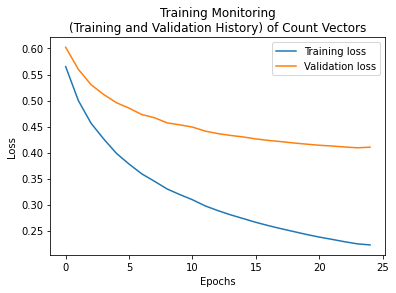

In [28]:
plt.plot(tr_loss_count, label='Training loss')
plt.plot(dev_loss_count, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring\n(Training and Validation History) of Count Vectors')
plt.legend()
plt.show()

##### Answer
Accroding to the results of training monitoring results, I can conduct that the model is about to right.

- It can be shown that both training loss and validation loss is decreasing with the increasing of the number of epoch, and at the end they both are close to a steady state.

- There is generation gap between the validation and training loss curve.

The way to prevent overfiting applied in this model includes:
- Adding L2 regularisation
- Stoping the traning when previous validation loss - current validation loss < the tolerance

#### Evaluation

Compute accuracy, precision, recall and F1-scores:

In [29]:
preds_te_count = predict_class(test_count, w_count)

print('Accuracy:', accuracy_score(label_test,preds_te_count))
print('Precision:', precision_score(label_test,preds_te_count))
print('Recall:', recall_score(label_test,preds_te_count))
print('F1-Score:', f1_score(label_test,preds_te_count))

Accuracy: 0.84
Precision: 0.8505154639175257
Recall: 0.825
F1-Score: 0.8375634517766498


Finally, print the top-10 words for the negative and positive class respectively.

In [30]:
top_neg = w_count.argsort()[:10]
top_pos = w_count.argsort()[::-1][:10]
print("Top 10 negative words: ",[id2word[i] for i in top_neg])
print("Top 10 positive words: ",[id2word[i] for i in top_pos])

Top 10 negative words:  ['bad', 'only', 'unfortunately', 'plot', 'why', 'worst', 'script', 'boring', 'any', 'nothing']
Top 10 positive words:  ['great', 'well', 'also', 'seen', 'life', 'many', 'fun', 'world', 'both', 'movies']


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

#### Answer: 
##### Feartures of classfication

It can been seen that the features generalised in this model is general fit as we excepted in movie review such as "great", "well","fun" etc as postive words, and the negative words as "bad","only","unfortunately" etc are also fit.
##### Classifier could pick up as important in the new domain?

The classifier made by count model is able to be applied in binary classfication as the features we picked above they are generally good to show postive or negative opinion. However they are very common words in English so it is not prefect to describe some specific domains such as laptop and restaurant reviews. For example, we are more common to use delicious, fresh to describe food but they are not usually to describe movie. So this Classifier can pick common positive words but that are not enough important in a new domain. In the later assignment, the tf-idf model will be applied to genralise  top features which is more accurate to classfy the movie review. By this way, the count model is better than tfidf model if you want to apply them  in a new domian such as laptop or resturant (Features from this model).

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

#### The optimisation strategies

The aim of optimisation is find the best fit parameter of learning rate and regularisation strength, which will make the model have better score in development set and test set. The L2 regularization is a general term for a class of methods in machine learning that introduce additional information to the original loss function in order to prevent overfitting and improve model generalization performance, learning rate also determined wheter the model can reach the steady state or not, in this assignment, the optimisation strategy is enumeration of the possible results to achieve a set of grid search first to find roughly range of parameters, then followed find the specific value which have the best performance. 

#### Optimising Learning Rate 
For the Learning Rate, I have set 0.00001, 0.0001 and 0.001 to do a gridsearch to find which range of parameter can have good performance with suitable number of epoches. It can be clear find that the larger learning rate will obviously reduce the number of epochs. When`lr=0.0001` it can be seen that the maximum epoches 200 can not finish the training which mean the Tr.loss and Val.loss can not reach to a steady state therefore the precision, recall and F-1 score are all lower than others. After this we can find the `lr=0.0001 and 0.001` could achievd a high precision and resonable epoch. As I set early stop epoch so it is diffcult to have obvious overfitting for fluctuation of the loss, but a larger learning rate may not help us find the best w. So I also did 0.00025, 0.0005 and 0.00075,

Initial parameters: `lr=0.0001, alpha=0.001`

| Trial | Learning rate | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|---------------|--------|----------|-----------|-----------|--------|----------|
| 1     | 0.00001        | 199     | 0.34   | 0.46    | 0.823  | 0.835 | 0.829   |
| 2     | 0.0001        | 84     | 0.181   | 0.397    | 0.832    | 0.845 | 0.835   |
| 3     | 0.00020         | 24     | 0.236  | 0.416    | 0.847    | 0.83 | 0.838   |
| 4     | 0.00025         | 24     | 0.208  | 0.405    | 0.852    | 0.84 | 0.846   |
| 5     | 0.00050         | 23     | 0.156  | 0.397    | 0.817    | 0.85 | 0.833   |
| 6     | 0.00075         | 14     | 0.153  | 0.394    | 0.84    | 0.84 | 0.839   |
| 7     | 0.001         | 10     | 0.156  | 0.397    | 0.848    | 0.835 | 0.841   |


The optimal `lr` is found to be `0.00025`, as the model has highest precision,recall and F1-Score on test test

#### Optimising Regularisation Strength
Then we did regularisation optimisation,the results was shown below. 
Initial parameters: `lr=0.00025, alpha=0.00001`

| Trial | Alpha      | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|------------|--------|----------|-----------|-----------|--------|----------|
| 1    | 0.00001    | 24     | 0.208   | 0.405   | 0.848    | 0.84  | 0.844   |
| 2    | 0.0001    | 24     | 0.208   | 0.405   | 0.848    | 0.84  | 0.844   |
| 3    | 0.0005    | 24     | 0.210   | 0.407   | 0.848    | 0.84  | 0.844   |
| 4    | 0.001   | 24     | 0.212   | 0.408   | 0.853    | 0.84  | 0.846   |
| 5    | 0.0015   | 24     | 0.214   | 0.410   | 0.853    | 0.84  | 0.846   
| 6    | 0.002   | 24     | 0.216   | 0.412   | 0.853    | 0.84  | 0.846   ||
| 7    | 0.01 | 24     | 0.248   | 0.437   | 0.851    | 0.825  | 0.838   |
| 8    | 0.1 | 7     | 0.43   | 0.54  | 0.824   | 0.8  | 0.812   |

The process is similar as learning rare optimisation. I firstly set Alpha in 0.0001, 0.001 and 0.01, the set 0.005, 0.01 and 0.002, it can be find the best walue should be `lr=0.00025, alpha=0.0005`


#### The relationship between learning rate and time
Acroding to the results, the relationship is that the learning rate is inversely proportional to the number of epoches. It can be iluustrate that by the formula of optimal  `w -= lr * (y * (predict_y - y) + 2 * alpha * weights)`, the larger learning rate will increase the size of changing weights which will reduce the number of epoches to the best value. However, the larger learning rate will cause the w in unsteady
state which make the model can not find the best fit value. The small learning rate will make larger epoch will cause large traning which may prevent the model can not reach the steady value in limited number of epoches. 

#### The relationship between regularisation strength and time
When regularisation strength is small, the alpha has very limited influence on reducing the time of traning but when alpha is large enough, the learning time will reduced more significantly. It also can be explained by the formula of `w -= lr * (y * (predict_y - y) + 2 * alpha * weights)`

#### The relationship between regularisation strength and model performance
The regularisation strenth is able to prevent the overfitting because it can introduce the generation gap of the model, however it is not very obvious in our model.



## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [31]:
w_idf, tr_loss_idf, dev_loss_idf = SGD(X_tr =train_tfidf,
                                             Y_tr=label_train,
                                             X_dev=dev_tfidf,
                                             Y_dev=label_dev,
                                            lr=0.005,
                                             alpha=0.0005,
                                             epochs=100)

Epoch: 0 | Training loss: 0.5734980942087012 | Validation loss: 0.6414608397340473
Epoch: 1 | Training loss: 0.49616926793591704 | Validation loss: 0.6071207464180456
Epoch: 2 | Training loss: 0.4412479916722209 | Validation loss: 0.5818417116931373
Epoch: 3 | Training loss: 0.39969634358297235 | Validation loss: 0.5623716005997227
Epoch: 4 | Training loss: 0.3669149241456118 | Validation loss: 0.5465204749449224
Epoch: 5 | Training loss: 0.34000583285998254 | Validation loss: 0.5339715321844216
Epoch: 6 | Training loss: 0.31759417310756344 | Validation loss: 0.5231327006907549
Epoch: 7 | Training loss: 0.2985281073438565 | Validation loss: 0.5133248783027828
Epoch: 8 | Training loss: 0.28192856480903655 | Validation loss: 0.5054081794162079
Epoch: 9 | Training loss: 0.2674982091939961 | Validation loss: 0.498248748748746
Epoch: 10 | Training loss: 0.25487767927534205 | Validation loss: 0.491694012412203
Epoch: 11 | Training loss: 0.243332208859801 | Validation loss: 0.4866651501546559

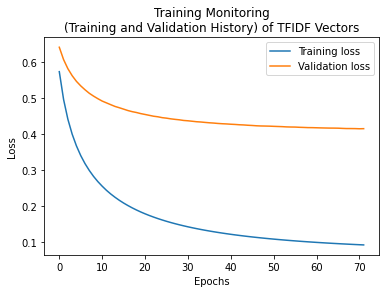

In [32]:
plt.plot(tr_loss_idf, label='Training loss')
plt.plot(dev_loss_idf, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring\n(Training and Validation History) of TFIDF Vectors')
plt.legend()
plt.show()

In [33]:
preds_te_idf = predict_class(test_tfidf, w_idf)
print('Accuracy:', accuracy_score(label_test,preds_te_idf))
print('Precision:', precision_score(label_test,preds_te_idf))
print('Recall:', recall_score(label_test,preds_te_idf))
print('F1-Score:', f1_score(label_test,preds_te_idf))
top_neg_idf = w_idf.argsort()[:10]
top_pos_idf = w_idf.argsort()[::-1][:10]
print("Top 10 negative words: ",[id2word[i] for i in top_neg_idf])
print("Top 10 positive words: ",[id2word[i] for i in top_pos_idf])

Accuracy: 0.885
Precision: 0.885
Recall: 0.885
F1-Score: 0.885
Top 10 negative words:  ['bad', 'worst', 'boring', 'unfortunately', 'supposed', 'ridiculous', 'script', 'awful', 'waste', 'poor']
Top 10 positive words:  ['hilarious', 'memorable', 'terrific', 'perfectly', 'great', 'overall', 'fun', 'definitely', 'perfect', 'pulp']


####  Answer about TF.IDF vectors
##### TF-IDF Vector Model
Accroding to the results of training monitoring results, I can conduct that the model is about to right.

- It can be shown that both training loss and validation loss is decreasing with the increasing of the number of epoch, and at the end they both are close to a steady state.

- There is generation gap between the validation and training loss curve.

The way to prevent overfiting applied in this model includes:
- Adding L2 regularisation
- Stoping the traning when previous validation loss - current validation loss < the toleranceAccroding to the results of training monitoring results, I can conduct that the model is about to right, which is similar to the Count model as I did before.

##### TF-IDF Vectors VS Count Vector
The TF-IDF vectors model acchived higher performance than the count vectors model which achieved nearly 90% accuracy and percision or recall score with less loss in training and validation. This can be explained by the  idea of TF-IDF model which is:if a word or phrase has a high frequency TF in one review but seldom appears in other articles which caused a  low IDF, so that the word or phrase has a good ability to distinguish from others, therefore the tfidf model is good to classfy in a specific domain. 

Therefore some common terms have higher frequency will not be exctract as the top features in TF-IDF model. There are more "senior" words which may more specific to describe moive such as 'memorable','hilarious' and 'terrific'. However, some general words which may used in many other fields may not sellected here, so the TF-IDF model may not performe well in a new domain.


###### Optimisation of parameter
The optimisation strategies is similar as the count vector as we did before, the results are shown in later table. The learning rate has been studies, the lr =  0.005 is the best.The alpha=0.0005 is keeping stay and it has no significant contribution on performance as we tryed manytimes on different value of alpha.

| Trial | Alpha      | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|------------|--------|----------|-----------|-----------|--------|----------|
| 1    | 0.001   | 99     |0.179 |  0.457| 0.901  | 0.87  | 0.885   |
| 2    | 0.005   | 71     |0.0838|  0.416  | 0.898    | 0.885  | 0.889 |
| 3    | 0.01 | 39     | 0.079 | 0.415   | 0.892    | 0.87  | 0.88   |
| 4    | 0.1 | 3     | 0.072 | 0.417 | 0.888   | 0.87  | 0.879   |

### Now repeat the training and evaluation process for BOW-tfidf, BOCN-count, BOCN-tfidf, BOW+BOCN including hyperparameter tuning for each model...

In [34]:
vocab_bocn, df_bocn, ngram_counts_bocn = get_vocab(text_train, keep_topN=5000, ngram_range=(3,5), char_ngrams = True)
_, df_bocn_dev, _ = get_vocab(text_dev, keep_topN=5000, ngram_range=(3,5), char_ngrams = True)
_, df_bocn_test, _ = get_vocab(text_test, keep_topN=5000, ngram_range=(3,5), char_ngrams = True)

In [35]:
train_ngram_char = (extract_ngrams(review, ngram_range=(3, 5),vocab= None, char_ngrams=True)for review in text_train)
test_ngram_char = (extract_ngrams(review, ngram_range=(3, 5),vocab=None, char_ngrams=True)for review in text_test)
dev_ngram_char = (extract_ngrams(review, ngram_range=(3, 5),vocab=None, char_ngrams=True)for review in text_dev)

In [36]:
train_count_bocn = vectorise(train_ngram_char, vocab_bocn)
dev_count_bocn = vectorise(dev_ngram_char, vocab_bocn)
test_count_bocn = vectorise(test_ngram_char, vocab_bocn)

train_bocn_tfidf = tfidf(train_count_bocn,vocab_bocn, df_bocn)
test_bocn_tfidf = tfidf(test_count_bocn,vocab_bocn, df_bocn_test)
dev_bocn_tfidf = tfidf(dev_count_bocn,vocab_bocn, df_bocn_dev)

### BOCN-count

In [37]:
#create a vocab_id to word dictionary
id2word_bocn = dict(enumerate(vocab_bocn))
word2id_bocn = {i:w for w, i in id2word_bocn.items()}

In [38]:
w_bocn, tr_loss_bocn, dev_loss_bocn = SGD(X_tr=train_count_bocn ,
                                             Y_tr=label_train,
                                             X_dev=dev_count_bocn,
                                             Y_dev=label_dev,
                                             lr=0.000005,
                                             alpha= 0.0005,
                                             tolerance=0.0000001,
                                             epochs=120)

Epoch: 0 | Training loss: 0.665144481390628 | Validation loss: 0.6690229230379364
Epoch: 1 | Training loss: 0.6430237028695055 | Validation loss: 0.6519319006917277
Epoch: 2 | Training loss: 0.62415381344542 | Validation loss: 0.6368922725453646
Epoch: 3 | Training loss: 0.6094404843855546 | Validation loss: 0.6255325104135585
Epoch: 4 | Training loss: 0.5945053291855354 | Validation loss: 0.6147328500898075
Epoch: 5 | Training loss: 0.5801373725520069 | Validation loss: 0.6051701564214917
Epoch: 6 | Training loss: 0.5681900975327835 | Validation loss: 0.5964370329126442
Epoch: 7 | Training loss: 0.5577961674608272 | Validation loss: 0.5900084414754514
Epoch: 8 | Training loss: 0.5471463357367443 | Validation loss: 0.5823257821384397
Epoch: 9 | Training loss: 0.5377485245978333 | Validation loss: 0.5759778557953351
Epoch: 10 | Training loss: 0.5339108676910305 | Validation loss: 0.5758924567477542
Epoch: 11 | Training loss: 0.5208575707630969 | Validation loss: 0.5651989098530129
Epoch

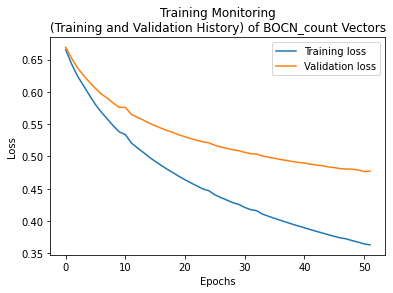

Accuracy: 0.825
Precision: 0.8037383177570093
Recall: 0.86
F1-Score: 0.8309178743961353
Top 10 negative words:  [('b', 'a', 'd'), ('e', 'r', 'e'), ('h', 'e', 'r'), ('p', 'l', 'o'), ('h', 'e', 'r', 'e'), ('p', 'l', 'o', 't'), ('l', 'o', 't'), ('o', 'n', 'l', 'y'), ('n', 'l', 'y'), ('o', 'r', 's')]
Top 10 positive words:  [('e', 'r', 'f'), ('e', 'a', 't'), ('l', 's', 'o'), ('r', 'e', 'a', 't'), ('r', 'e', 'a'), ('t', 'r', 'u'), ('g', 'r', 'e'), ('a', 'l', 's'), ('a', 'l', 's', 'o'), ('g', 'r', 'e', 'a')]


In [39]:
plt.plot(tr_loss_bocn, label='Training loss')
plt.plot(dev_loss_bocn, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring\n(Training and Validation History) of BOCN_count Vectors')
plt.legend()
plt.show()

preds_te_bocn_count = predict_class(test_count_bocn, w_bocn)
print('Accuracy:', accuracy_score(label_test,preds_te_bocn_count))
print('Precision:', precision_score(label_test,preds_te_bocn_count))
print('Recall:', recall_score(label_test,preds_te_bocn_count))
print('F1-Score:', f1_score(label_test,preds_te_bocn_count))

top_neg_bocn_count =  w_bocn.argsort()[:10]
top_pos_bocn_count =  w_bocn.argsort()[::-1][:10]
print("Top 10 negative words: ",[id2word_bocn[i] for i in top_neg_bocn_count ])
print("Top 10 positive words: ",[id2word_bocn[i] for i in top_pos_bocn_count ])


###### Optimisation of parameter
For saving time we just did Learning rate optimisation with alpha = 0.0005, the results are shown below.

| Trial | LR| Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|------------|--------|----------|-----------|-----------|--------|----------|
| 1    | 0.00001   | 10     |0.468 | 0.536| 0.87  | 0.72  | 0.78   |
| 2    | 0.000005   | 51    |0.362| 0.477  | 0.81   | 0.86 | 0.831 |
| 3    | 0.000001 | 119     | 0.449| 0.522   | 0.800   | 0.835  | 0.817   |


##### BOCN_Count Model  Performance
Accroding to the results of training monitoring results, I can conduct that the model is about to right
- It can be shown that both training loss and validation loss is decreasing with the increasing of the number of epoch, and at the end they both are close to a steady state.
- There is generation gap between the validation and training loss curve.
- Although there is tiny fluctuations in training and validation loss but it is very tiny


The way to prevent overfiting applied in this model includes:
- Adding L2 regularisation
- Stoping the traning when previous validation loss - current validation loss < the toleranceAccroding to the results of training monitoring results, I can conduct that the model is about to right

### BOCN-tfidf

In [40]:
w_bocn_tfidf, tr_loss_bocn_tfidf, dev_loss_bocn_tfidf = SGD(
                                             X_tr=train_bocn_tfidf,
                                             Y_tr=label_train,
                                             X_dev=dev_bocn_tfidf,
                                             Y_dev=label_dev,
                                             lr=0.005,
                                             alpha=0.0005,
                                             tolerance=0.000001,
                                             epochs=120)

Epoch: 0 | Training loss: 0.5172067790049116 | Validation loss: 0.5732246055737349
Epoch: 1 | Training loss: 0.4341634112728102 | Validation loss: 0.5204595063179391
Epoch: 2 | Training loss: 0.3828159045845367 | Validation loss: 0.4885246286181739
Epoch: 3 | Training loss: 0.3496461450432576 | Validation loss: 0.4707983462436573
Epoch: 4 | Training loss: 0.32022445353040146 | Validation loss: 0.45432027997125973
Epoch: 5 | Training loss: 0.29784812019365275 | Validation loss: 0.443483943451546
Epoch: 6 | Training loss: 0.28006427140739315 | Validation loss: 0.4356257022552914
Epoch: 7 | Training loss: 0.26607155907431035 | Validation loss: 0.43106470218117826
Epoch: 8 | Training loss: 0.2521024199142883 | Validation loss: 0.425338599432668
Epoch: 9 | Training loss: 0.24110191718475912 | Validation loss: 0.4223108404851139
Epoch: 10 | Training loss: 0.23435375009539086 | Validation loss: 0.4236337167420851
Finshed the traning at epoch:  10


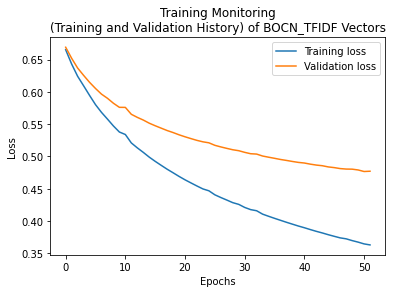

Accuracy: 0.8425
Precision: 0.8784530386740331
Recall: 0.795
F1-Score: 0.8346456692913387
Top 10 negative words:  [('b', 'a', 'd'), ('w', 'o', 'r', 's'), ('w', 'a', 's', 't', 'e'), ('w', 'a', 's', 't'), ('w', 'o', 'r', 's', 't'), ('a', 'm', 'm'), ('w', 'a', 's'), ('b', 'o', 'r', 'i'), ('b', 'o', 'r', 'i', 'n'), ('o', 'r', 's', 't')]
Top 10 positive words:  [('h', 'i', 'l', 'a'), ('i', 'l', 'a', 'r'), ('r', 'f', 'e', 'c'), ('e', 'r', 'f', 'e', 'c'), ('p', 'e', 'r', 'f', 'e'), ('r', 'f', 'e', 'c', 't'), ('e', 'r', 'f', 'u', 'l'), ('g', 'r', 'e', 'a'), ('g', 'r', 'e', 'a', 't'), ('r', 'f', 'u', 'l')]


In [41]:
plt.plot(tr_loss_bocn, label='Training loss')
plt.plot(dev_loss_bocn, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring\n(Training and Validation History) of BOCN_TFIDF Vectors')
plt.legend()
plt.show()

preds_te_bocn_tfidf = predict_class(test_bocn_tfidf, w_bocn_tfidf)
print('Accuracy:', accuracy_score(label_test,preds_te_bocn_tfidf))
print('Precision:', precision_score(label_test,preds_te_bocn_tfidf))
print('Recall:', recall_score(label_test,preds_te_bocn_tfidf))
print('F1-Score:', f1_score(label_test,preds_te_bocn_tfidf))

top_neg_bocn_tfidf =  w_bocn_tfidf.argsort()[:10]
top_pos_bocn_tfidf =  w_bocn_tfidf.argsort()[::-1][:10]
print("Top 10 negative words: ",[id2word_bocn[i] for i in top_neg_bocn_tfidf ])
print("Top 10 positive words: ",[id2word_bocn[i] for i in top_pos_bocn_tfidf ])

###### Optimisation of parameter
For saving time we just did Learning rate optimisation with alpha = 0.0005, the results are shown below.

| Trial | LR| Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|------------|--------|----------|-----------|-----------|--------|----------|
| 1    | 0.0001   | 119     |0.417 | 0.509| 0.820  | 0.845 |0.832  |
| 2    | 0.001   | 51    |0.227 | 0.430 | 0.838   | 0.83 | 0.834 |
| 3    | 0.005 | 7     | 0.247 | 0.437 | 0.878  | 0.795| 0.841  |
| 4    | 0.01 | 7     |0.211 |  0.431  | 0.859  | 0.825| 0.834 |

##### BOCN TF-IDF Vector Model
Accroding to the results of training monitoring results, I can conduct that the model is about to right.

- It can be shown that both training loss and validation loss is decreasing with the increasing of the number of epoch, and at the end they both are close to a steady state.

- There is generation gap between the validation and training loss curve.

- Although there is tiny fluctuations in training and validation loss but it is very tiny

The way to prevent overfiting applied in this model includes:
- Adding L2 regularisation
- Stoping the traning when previous validation loss - current validation loss < the toleranceAccroding to the results of training monitoring results, I can conduct that the model is about to right.

### Feartures of classfication and performance analysis
As expceted, in BOCN, the tfidf has better performance than count vector model, the reason is same as I stated before. It seemed that both BOCN count model and tfidf model both generate some sequence letters from words such as "bad", "bori" from "boring" in negative words and "prefe" from "prefect". These feartures are basically right as we excepeted and the accuracy is also OK which is higher than 80%.

But the overall performance is lower than the BOW model. This may be caused by the BOCN model is too speicific and sequence of letters are specific and not enough to carry enough information compared with words(or bag of words), so they are not same distinguishable as BOW model.

#### The `ngram_range` and performance
I have noticed that the `ngram_range` have great influence on the model performance. If we set `ngram_range` as small range eg (1,2), the accuracy of model is very poor, if the range is large, the performance will increase obviously, this may be caused by the larger range will help the BOCN model to carry more useful information. It is easy to be understant just "a", "b", "c" will not informe the system anything. Larger number of letter can form the word or phrase to carry more information.

### BOW+BOCN count and TF-IDF vectors	

In [42]:
bow_bocn = set(list(vocab) + list(vocab_bocn))

In [43]:
train_count_bow_bocn = np.column_stack((train_count, train_count_bocn))
dev_count_bow_bocn = np.column_stack((dev_count, dev_count_bocn))
test_count_bow_bocn = np.column_stack((test_count, test_count_bocn))

train_bow_bocn_tfidf = tfidf(train_count_bow_bocn,bow_bocn, df + df_bocn)
test_bow_bocn_tfidf = tfidf(test_count_bow_bocn,bow_bocn, test_df + df_bocn_test)
dev_bow_bocn_tfidf = tfidf(dev_count_bow_bocn,bow_bocn, dev_df + df_bocn_dev)

id2word_bow_bocn = dict(enumerate(bow_bocn))
word2id_bow_bocn = {i:w for w, i in id2word_bow_bocn.items()}

In [44]:
w_bow_bocn, tr_loss_bow_bocn, dev_loss_bow_bocn = SGD(X_tr=train_count_bow_bocn ,
                                             Y_tr=label_train,
                                             X_dev=dev_count_bow_bocn,
                                             Y_dev=label_dev,
                                             lr=0.000005,
                                             alpha=0.00005,
                                             tolerance=0.0000001,
                                             epochs=120)

Epoch: 0 | Training loss: 0.6615924979004739 | Validation loss: 0.6664489396450626
Epoch: 1 | Training loss: 0.6368882677629472 | Validation loss: 0.6475448459940978
Epoch: 2 | Training loss: 0.6160897393001382 | Validation loss: 0.6312092522115937
Epoch: 3 | Training loss: 0.5998755709429534 | Validation loss: 0.6189664946742427
Epoch: 4 | Training loss: 0.5836527449435683 | Validation loss: 0.6074024720173318
Epoch: 5 | Training loss: 0.5681845123988343 | Validation loss: 0.5971554624852492
Epoch: 6 | Training loss: 0.5552811746007312 | Validation loss: 0.5878871936123389
Epoch: 7 | Training loss: 0.5440753936476918 | Validation loss: 0.5809462397167531
Epoch: 8 | Training loss: 0.5326782999974125 | Validation loss: 0.5728719628766651
Epoch: 9 | Training loss: 0.5226209016539207 | Validation loss: 0.5662098101524545
Epoch: 10 | Training loss: 0.5181107256237484 | Validation loss: 0.5655327405859191
Epoch: 11 | Training loss: 0.5046132019326564 | Validation loss: 0.5547860821296814
Ep

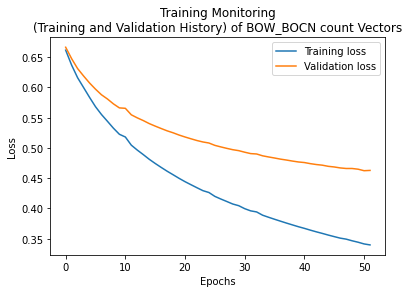

Accuracy: 0.8325
Precision: 0.812206572769953
Recall: 0.865
F1-Score: 0.837772397094431
Top 10 negative words:  [('years', 'after'), 'bates', 'killed', ('o', 'r', 'd', 'e', 'r'), 'rely', 'inability', ('y', 't', 'h', 'i'), 'primarily', 'harsh', ('a', 'r', 'i', 'o')]
Top 10 positive words:  [('film', 'even'), ('r', 't', 'r', 'a', 'y'), 'nicole', ('s', 'i', 'n', 'e'), 'mitchell', ('e', 'n', 'c', 'e', 's'), ('p', 'p', 'a'), ('i', 'c', 't', 'u', 'r'), 'eve', 'dry']


In [45]:
plt.plot(tr_loss_bow_bocn, label='Training loss')
plt.plot(dev_loss_bow_bocn, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring\n(Training and Validation History) of BOW_BOCN count Vectors')
plt.legend()
plt.show()

preds_te_bow_bocn = predict_class(test_count_bow_bocn, w_bow_bocn)
print('Accuracy:', accuracy_score(label_test,preds_te_bow_bocn))
print('Precision:', precision_score(label_test,preds_te_bow_bocn))
print('Recall:', recall_score(label_test,preds_te_bow_bocn))
print('F1-Score:', f1_score(label_test,preds_te_bow_bocn))

top_neg_bow_bocn = w_bow_bocn.argsort()[:10]
top_pos_bow_bocn =  w_bow_bocn.argsort()[::-1][:10]
print("Top 10 negative words: ",[id2word_bow_bocn[i] for i in top_neg_bow_bocn ])
print("Top 10 positive words: ",[id2word_bow_bocn[i] for i in top_pos_bow_bocn ])

In [46]:
w_bow_bocn_tfidf, tr_loss_bow_bocn_tfidf, dev_loss_bow_bocn_tfidf = SGD(X_tr=train_bow_bocn_tfidf ,
                                             Y_tr=label_train,
                                             X_dev=dev_bow_bocn_tfidf,
                                             Y_dev=label_dev,
                                             lr=0.0001,
                                             alpha=0.00005,
                                             tolerance=0.0000001,
                                             epochs=120)

Epoch: 0 | Training loss: 0.6608429458300247 | Validation loss: 0.6691947897546728
Epoch: 1 | Training loss: 0.6334555654394456 | Validation loss: 0.6502877160280992
Epoch: 2 | Training loss: 0.6093982783651053 | Validation loss: 0.6329951442117268
Epoch: 3 | Training loss: 0.589566059502711 | Validation loss: 0.6185304483284697
Epoch: 4 | Training loss: 0.569674362324773 | Validation loss: 0.6049878541947781
Epoch: 5 | Training loss: 0.552322320822344 | Validation loss: 0.593425231359202
Epoch: 6 | Training loss: 0.5369765822539331 | Validation loss: 0.5826905190289685
Epoch: 7 | Training loss: 0.5236454323591848 | Validation loss: 0.5744503129080342
Epoch: 8 | Training loss: 0.510124156241307 | Validation loss: 0.564543998826588
Epoch: 9 | Training loss: 0.49833991336040223 | Validation loss: 0.5567074413104462
Epoch: 10 | Training loss: 0.4902610759009758 | Validation loss: 0.5527858912356107
Epoch: 11 | Training loss: 0.47724808589750534 | Validation loss: 0.5426527686758168
Epoch:

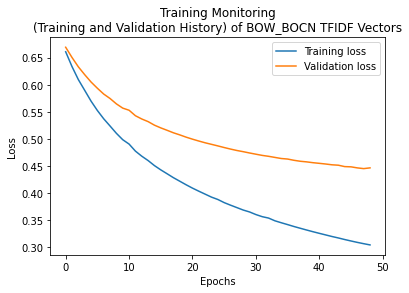

Accuracy: 0.8475
Precision: 0.8492462311557789
Recall: 0.845
F1-Score: 0.8471177944862155
Top 10 negative words:  ['bates', ('years', 'after'), 'superman', 'inability', 'primarily', 'ludicrous', 'harsh', ('runs', 'into'), ('first', 'rate'), 'philip']
Top 10 positive words:  ['nicole', ('film', 'even'), 'michelle', ('some', 'very'), 'mitchell', 'explaining', 'dry', 'warrior', ('come', 'off'), 'demonstrates']


In [47]:
plt.plot(tr_loss_bow_bocn_tfidf, label='Training loss')
plt.plot(dev_loss_bow_bocn_tfidf, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring\n(Training and Validation History) of BOW_BOCN TFIDF Vectors')
plt.legend()
plt.show()

preds_te_bow_bocn_tfidf = predict_class(test_bow_bocn_tfidf, w_bow_bocn_tfidf)
print('Accuracy:', accuracy_score(label_test,preds_te_bow_bocn_tfidf))
print('Precision:', precision_score(label_test,preds_te_bow_bocn_tfidf))
print('Recall:', recall_score(label_test,preds_te_bow_bocn_tfidf))
print('F1-Score:', f1_score(label_test,preds_te_bow_bocn_tfidf))

top_neg_bow_bocn_idf = w_bow_bocn_tfidf.argsort()[:10]
top_pos_bow_bocn_idf =  w_bow_bocn_tfidf.argsort()[::-1][:10]
print("Top 10 negative words: ",[id2word_bow_bocn[i] for i in top_neg_bow_bocn_idf ])
print("Top 10 positive words: ",[id2word_bow_bocn[i] for i in top_pos_bow_bocn_idf ])

Accroding to the results of training monitoring results of both BOW-BOCN count and TF-IDF model, I can conduct those models are about to right.

- It can be shown that both training loss and validation loss is decreasing with the increasing of the number of epoch, and at the end they both are close to a steady state.

- There is generation gap between the validation and training loss curve.

The way to prevent overfiting applied in this model includes:
- Adding L2 regularisation
- Stoping the traning when previous validation loss - current validation loss < the tolerance

###### Optimisation of parameter
For saving time we just did Learning rate optimisation with alpha = 0.00005 on the tfidf vector, the results are shown below.

| Trial | LR| Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|------------|--------|----------|-----------|-----------|--------|----------|
| 1   | 0.00001   | 73    |0.262| 0.428 | 0.842   | 0.844 | 0.842 |
| 2   | 0.00002 | 58     |0.209| 0.411 | 0.838  | 0.855| 0.846  |
| 3    | 0.0001 | 23     |0.221| 0.420  | 0.844  | 0.84| 0.842 |

### Feartures of classfication and performance analysis
As expected, in BOCN-BOW model, the TF-IDF model have better performance. The BOCN-BOW is also achieved very high performance.

The BOCN-BOW should be provided the best performance beacause this model contains the most information compared by the single BOW or BOCN model it contains n_grams of words and characters which is potential to cover all useful information. But in this project the overall performance is slitely lower than the BOW model. This may caused by I did not do very carefull optimisation here and it not reach to the maximum performance. There is one another possibility is that we have changed the shape of matrix and there is more features in BOW-BOCN as 10000 vs 5000 in BOW or BOCN, that might also changed the quality of data so influences the performances. 

The features extract here is not very clear than the BOW model but it also contains some words can express the attitudes.eg. Positive: 'respective', 'intellectual', negative: 'foul', ('c', 'h', 'o', 'o', 'l') It has been notice that the features are mainly bag of words but not the characters n-gram. This also can conduct the Bag of words is better than the BOCN model.



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.853  |0.84	   |0.846  |	
| BOW-tfidf  | 0.898  |0.885   |0.889  |		
| BOCN-count  | 0.81  |	0.86   |0.831  |	
| BOCN-tfidf  | 0.859 |0.825   |0.834  |		
| BOW+BOCN  |  0.847 | 0.885  |  0.865 |

Please discuss why your best performing model is better than the rest.

##### Answer

Generally speaking, all 5 models preforms well and all of them achieved high performances which all > 80 %  in F1-scores, but we can still rank them: 

BOW-tfidf > BOW+BOCN(tfidf) > BOW-count > BOCN-TFIDF > BOCN-count 

It can be concluded that the BOW model is better than BOCN model and tfidf is better than the count model,while BOW + BOCN is between two of them but it should rank first because it provides both specific and words information.The reason to cause that might be I have changed the shape of matrix as I mentioned above.

The reason of BOW model better is that the words or bag of words is able to carry more useful information, by contrast, the BOCN may not carry enough information which can be helpful to classfy the movie reviews.

We can make a summary as below:

The TF-IDF model have better performance is because TF-IDF contains information on the more important words and the less important ones as well, the important words have higher score than the common "good" or "bad" words, so IDF-TF model performs better in binary classfication, and it can extract more specific features than the counts model.

Generally, all model is performed as we expected.